In [1]:
import os
import glob
import shutil
import random
from pathlib import Path
import numpy as np
import pandas as pd
import tensorflow as tf
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import image_dataset_from_directory
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping, Callback
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
from collections import Counter
import matplotlib.pyplot as plt

In [2]:
original_dir = r"C:\Users\Hibatullah\CA\DL\Project\weather"
split_dir = r"C:\Users\Hibatullah\CA\DL\Project\weather_split"

train_ratio = 0.7
val_ratio = 0.15
test_ratio = 0.15
batch_size = 32
img_height = 180
img_width = 180
seed = 123


In [3]:

class_names = [d.name for d in Path(original_dir).iterdir() if d.is_dir()]
print("Classes found:", class_names)

for class_name in class_names:
    class_dir = os.path.join(original_dir, class_name)
    valid_exts = ['.jpg', '.jpeg', '.png', '.bmp']
    images = [img for img in Path(class_dir).iterdir() if img.suffix.lower() in valid_exts]  
    
    random.shuffle(images)
    
    n_total = len(images)
    n_train = int(train_ratio * n_total)
    n_val = int(val_ratio * n_total)
    n_test = n_total - n_train - n_val
    
    train_images = images[:n_train]
    val_images = images[n_train:n_train + n_val]
    test_images = images[n_train + n_val:]
    
    print(f"{class_name}: Total={n_total}, Train={len(train_images)}, Val={len(val_images)}, Test={len(test_images)}")
    
    for split_name, split_images in zip(['train', 'val', 'test'], [train_images, val_images, test_images]):
        target_class_dir = os.path.join(split_dir, split_name, class_name)
        os.makedirs(target_class_dir, exist_ok=True)
        
        for img_path in split_images:
            shutil.copy(img_path, target_class_dir)

Classes found: ['cloudy', 'foggy', 'lightning', 'rainbow', 'rainy', 'rime', 'sandstorm', 'sunrise']
cloudy: Total=349, Train=244, Val=52, Test=53
foggy: Total=384, Train=268, Val=57, Test=59
lightning: Total=400, Train=280, Val=60, Test=60
rainbow: Total=450, Train=315, Val=67, Test=68
rainy: Total=383, Train=268, Val=57, Test=58
rime: Total=400, Train=280, Val=60, Test=60
sandstorm: Total=400, Train=280, Val=60, Test=60
sunrise: Total=349, Train=244, Val=52, Test=53


In [4]:
from PIL import Image
import os

def scan_invalid_images(root_dir):
    supported_exts = ('.jpg', '.jpeg', '.png', '.bmp')
    invalid_images = []

    for subdir, _, files in os.walk(root_dir):
        for file in files:
            path = os.path.join(subdir, file)
            if not file.lower().endswith(supported_exts):
                invalid_images.append(path)
                continue
            try:
                with Image.open(path) as img:
                    img.verify()
            except:
                invalid_images.append(path)
    
    print(f"\n🛑 Found {len(invalid_images)} invalid image files:")
    for bad_file in invalid_images:
        print(bad_file)

# Change this to your dataset root directory
scan_invalid_images(r"C:\Users\Hibatullah\CA\DL\Project\weather_split")



🛑 Found 0 invalid image files:


In [5]:
import tensorflow as tf
import glob
import os

def find_bad_images_tf(root_dir):
    supported_exts = ['*.jpg', '*.jpeg', '*.png', '*.bmp']
    image_paths = []

    for ext in supported_exts:
        image_paths.extend(glob.glob(os.path.join(root_dir, '**', ext), recursive=True))

    print(f"🔍 Scanning {len(image_paths)} files...\n")

    for img_path in image_paths:
        try:
            img_raw = tf.io.read_file(img_path)
            _ = tf.io.decode_image(img_raw, channels=3)  # Will raise error if not decodable
        except Exception as e:
            print(f"\n❌ Bad image: {img_path}")
            print(f"    Error: {e}")
            return img_path

    print("✅ All files passed TensorFlow decoding.")

# Use it on your full dataset folder
bad_image_path = find_bad_images_tf(r"C:\Users\Hibatullah\CA\DL\Project\weather_split")


🔍 Scanning 7335 files...


❌ Bad image: C:\Users\Hibatullah\CA\DL\Project\weather_split\val\rainy\rainy (77).jpg
    Error: {{function_node __wrapped__DecodeImage_device_/job:localhost/replica:0/task:0/device:CPU:0}} Unknown image file format. One of JPEG, PNG, GIF, BMP required. [Op:DecodeImage] name: 


In [6]:
import os

bad_file = r"C:\Users\Hibatullah\CA\DL\Project\weather_split\train\rainy\rainy (77).jpg"
if os.path.exists(bad_file):
    os.remove(bad_file)
    print(f"🗑️ Deleted: {bad_file}")
else:
    print("File not found.")


File not found.


In [7]:
train_dir = os.path.join(split_dir, 'train')
val_dir = os.path.join(split_dir, 'val')
test_dir = os.path.join(split_dir, 'test')

train_ds = tf.keras.utils.image_dataset_from_directory(
    train_dir,
    seed = seed,
    image_size = (img_height, img_width),
    batch_size = batch_size,
    shuffle = False
)

val_ds = tf.keras.utils.image_dataset_from_directory(
    val_dir,
    seed = seed,
    image_size = (img_height, img_width),
    batch_size = batch_size,
    shuffle = False
)

test_ds = tf.keras.utils.image_dataset_from_directory(
    test_dir,
    seed = seed,
    image_size = (img_height, img_width),
    batch_size = batch_size,
    shuffle = False
)

class_names = train_ds.class_names
print("Classes:", class_names)

Found 3112 files belonging to 8 classes.
Found 2104 files belonging to 8 classes.
Found 2119 files belonging to 8 classes.
Classes: ['cloudy', 'foggy', 'lightning', 'rainbow', 'rainy', 'rime', 'sandstorm', 'sunrise']


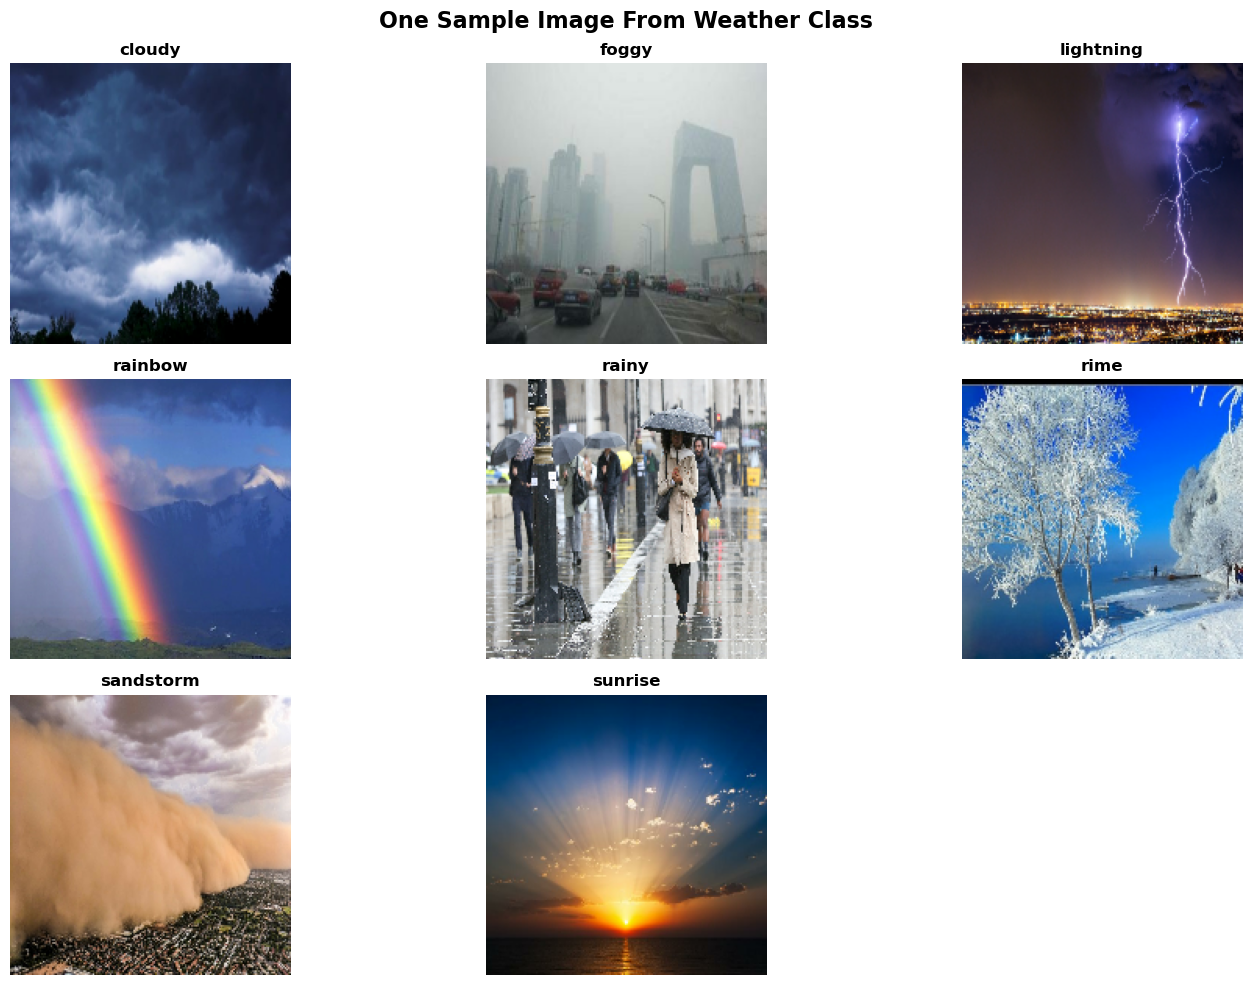

In [8]:
plt.figure(figsize=(15, 10))
displayed_classes = set()
images_to_show = []

for images, labels in train_ds:
    for i in range(len(images)):
        class_idx = labels[i].numpy()
        if class_idx not in displayed_classes:
            images_to_show.append((images[i], class_idx))
            displayed_classes.add(class_idx)
        if len(images_to_show) == len(class_names):
            break
    if len(images_to_show) == len(class_names):
        break

for i, (image, label_idx) in enumerate(images_to_show):
    ax = plt.subplot(3, 3, i+1)
    plt.imshow(image.numpy().astype("uint8"))
    plt.title(f"{class_names[label_idx]}", fontsize=12, fontweight='bold')
    plt.axis("off")

plt.suptitle("One Sample Image From Weather Class", fontsize=16, fontweight='bold')
plt.tight_layout()
plt.show()

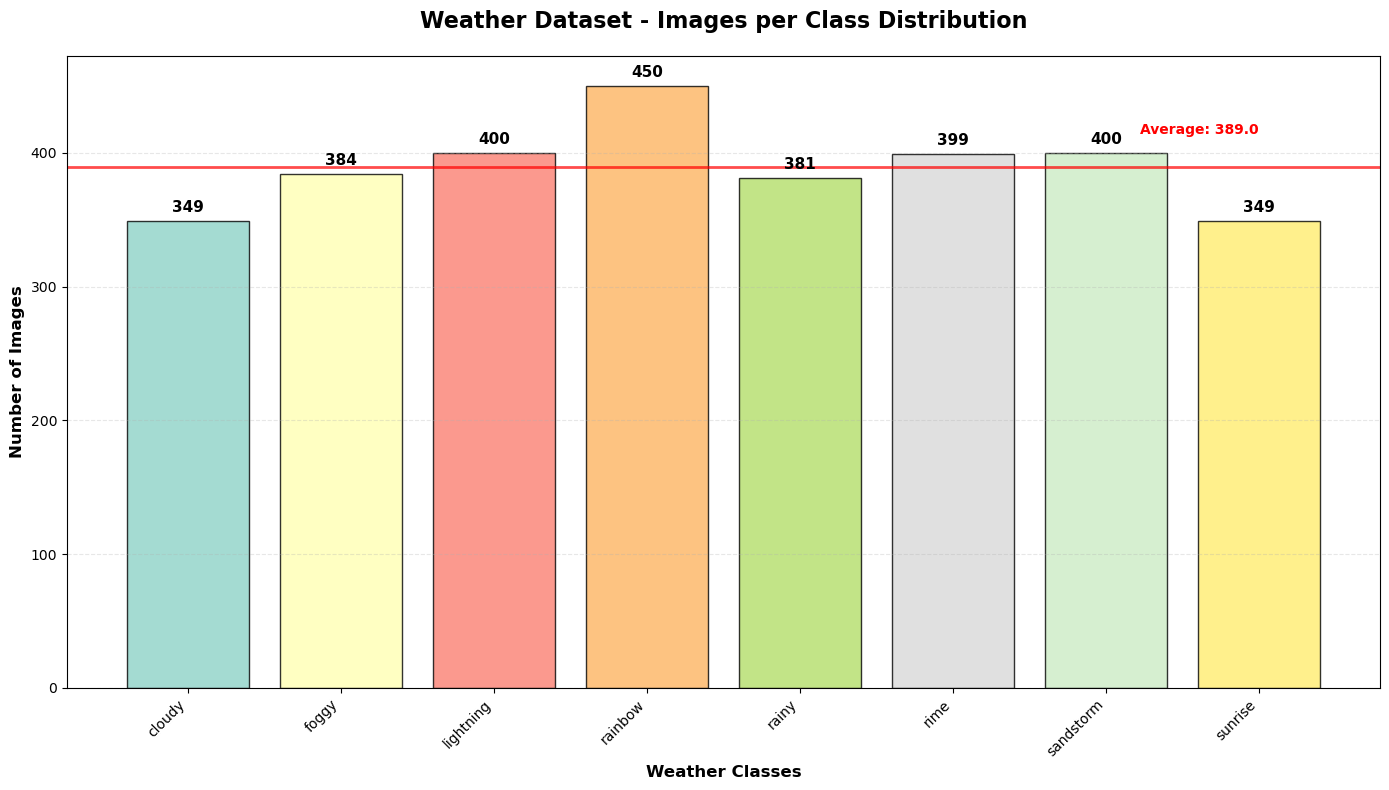


📊 Summary:
Total classes: 8
Total images: 3112
Average per class: 389.0
Most common: rainbow (450 images)
Least common: cloudy (349 images)
✅ Dataset is well balanced


In [9]:
class_counts = Counter()

for _, labels in train_ds.unbatch():
    class_idx = int(labels.numpy())
    class_counts[class_idx] += 1

class_indices = sorted(class_counts.keys())
counts = [class_counts[idx] for idx in class_indices]
names = [class_names[idx] for idx in class_indices]
total_images = sum(counts)

plt.figure(figsize=(14, 8))
colors = plt.cm.Set3(np.linspace(0, 1, len(names)))  # Different colors for each bar
bars = plt.bar(names, counts, color=colors, edgecolor='black', alpha=0.8)

for bar, count in zip(bars, counts):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + max(counts)*0.01, 
             str(count), ha='center', va='bottom', fontweight='bold', fontsize=11)

plt.title('Weather Dataset - Images per Class Distribution', fontsize=16, fontweight='bold', pad=20)
plt.xlabel('Weather Classes', fontweight='bold', fontsize=12)
plt.ylabel('Number of Images', fontweight='bold', fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y', alpha=0.3, linestyle='--')

# Draw average line
avg_line = total_images / len(class_counts)
plt.axhline(y=avg_line, color='red', linestyle='-', alpha=0.7, linewidth=2)
plt.text(len(names)-1, avg_line + max(counts)*0.05, f'Average: {avg_line:.1f}', 
         ha='right', va='bottom', color='red', fontweight='bold')

plt.tight_layout()
plt.show()

print("\n📊 Summary:")
print(f"Total classes: {len(class_counts)}")
print(f"Total images: {total_images}")
print(f"Average per class: {avg_line:.1f}")
print(f"Most common: {class_names[max(class_counts, key=class_counts.get)]} ({max(class_counts.values())} images)")
print(f"Least common: {class_names[min(class_counts, key=class_counts.get)]} ({min(class_counts.values())} images)")

if max(class_counts.values()) / min(class_counts.values()) > 2:
    print("⚠️  Dataset appears imbalanced")
else:
    print("✅ Dataset is well balanced")


In [10]:
class TrainingHistory(Callback):
    def __init__(self):
        self.history = {
            'loss' : [],
            'accuracy' : [],
            'val_loss' : [],
            'val_accuracy' :[],
            'learning_rate' : [] }
        
    def on_epoch_end(self, epoch, logs=None):
        self.history['loss'].append(logs.get('loss'))
        self.history['accuracy'].append(logs.get('accuracy'))
        self.history['val_loss'].append(logs.get('val_loss'))
        self.history['val_accuracy'].append(logs.get('val_accuracy'))
        self.history['learning_rate'].append(float(self.model.optimizer.learning_rate))

In [11]:
hyperparameter_combinations = [
    {
        'learning_rate': 0.001,
        'batch_size': 32,
        'filters_1': 32,
        'filters_2': 64,
        'filters_3': 128,
        'dense_units': 128,
        'dropout_rate': 0.3,
        'optimizer': 'adam'
    },
    {
        'learning_rate': 0.0005,
        'batch_size': 64,
        'filters_1': 64,
        'filters_2': 128,
        'filters_3': 256,
        'dense_units': 256,
        'dropout_rate': 0.4,
        'optimizer': 'adam'
    },
    {
        'learning_rate': 0.001,
        'batch_size': 16,
        'filters_1': 16,
        'filters_2': 32,
        'filters_3': 64,
        'dense_units': 64,
        'dropout_rate': 0.2,
        'optimizer': 'adam'
    },
    {
        'learning_rate': 0.0001,
        'batch_size': 32,
        'filters_1': 32,
        'filters_2': 64,
        'filters_3': 64,
        'dense_units': 128,
        'dropout_rate': 0.5,
        'optimizer': 'adam'
    },
    {
        'learning_rate': 0.001,
        'batch_size': 32,
        'filters_1': 64,
        'filters_2': 64,
        'filters_3': 128,
        'dense_units': 512,
        'dropout_rate': 0.3,
        'optimizer': 'adam'
    },
    {
        'learning_rate': 0.002,
        'batch_size': 32,
        'filters_1': 128,
        'filters_2': 128,
        'filters_3': 256,
        'dense_units': 256,
        'dropout_rate': 0.4,
        'optimizer': 'adam'
    }
]

In [1]:
def create_model (hyperparams, input_shape, num_classes):
    input_shape = (128, 128, 3) 
    model = Sequential([
        Conv2D(hyperparams['filters_1'], (3,3), activation='relu', input_shape=input_shape),
        BatchNormalization(),
        MaxPooling2D((2,2)),

        Conv2D(hyperparams['filters_2'], (3,3), activation='relu'),
        MaxPooling2D((2,2)),

        Conv2D(hyperparams['filters_3'], (3,3), activation='relu', input_shape=input_shape),
        BatchNormalization(),
        MaxPooling2D((2,2)),

        Flatten(),
        Dense(hyperparams['dense_units'], activation='relu'),
        Dropout(hyperparams['dropout_rate']),
        Dense(num_classes, activation='softmax')
    ])
    model = create_model(hyperparams, input_shape, num_classes)

In [ ]:

    model.summary()



🔧 Model 1 - Hyperparameters:
{'learning_rate': 0.001, 'batch_size': 32, 'filters_1': 32, 'filters_2': 64, 'filters_3': 128, 'dense_units': 128, 'dropout_rate': 0.3, 'optimizer': 'adam'}


RecursionError: maximum recursion depth exceeded

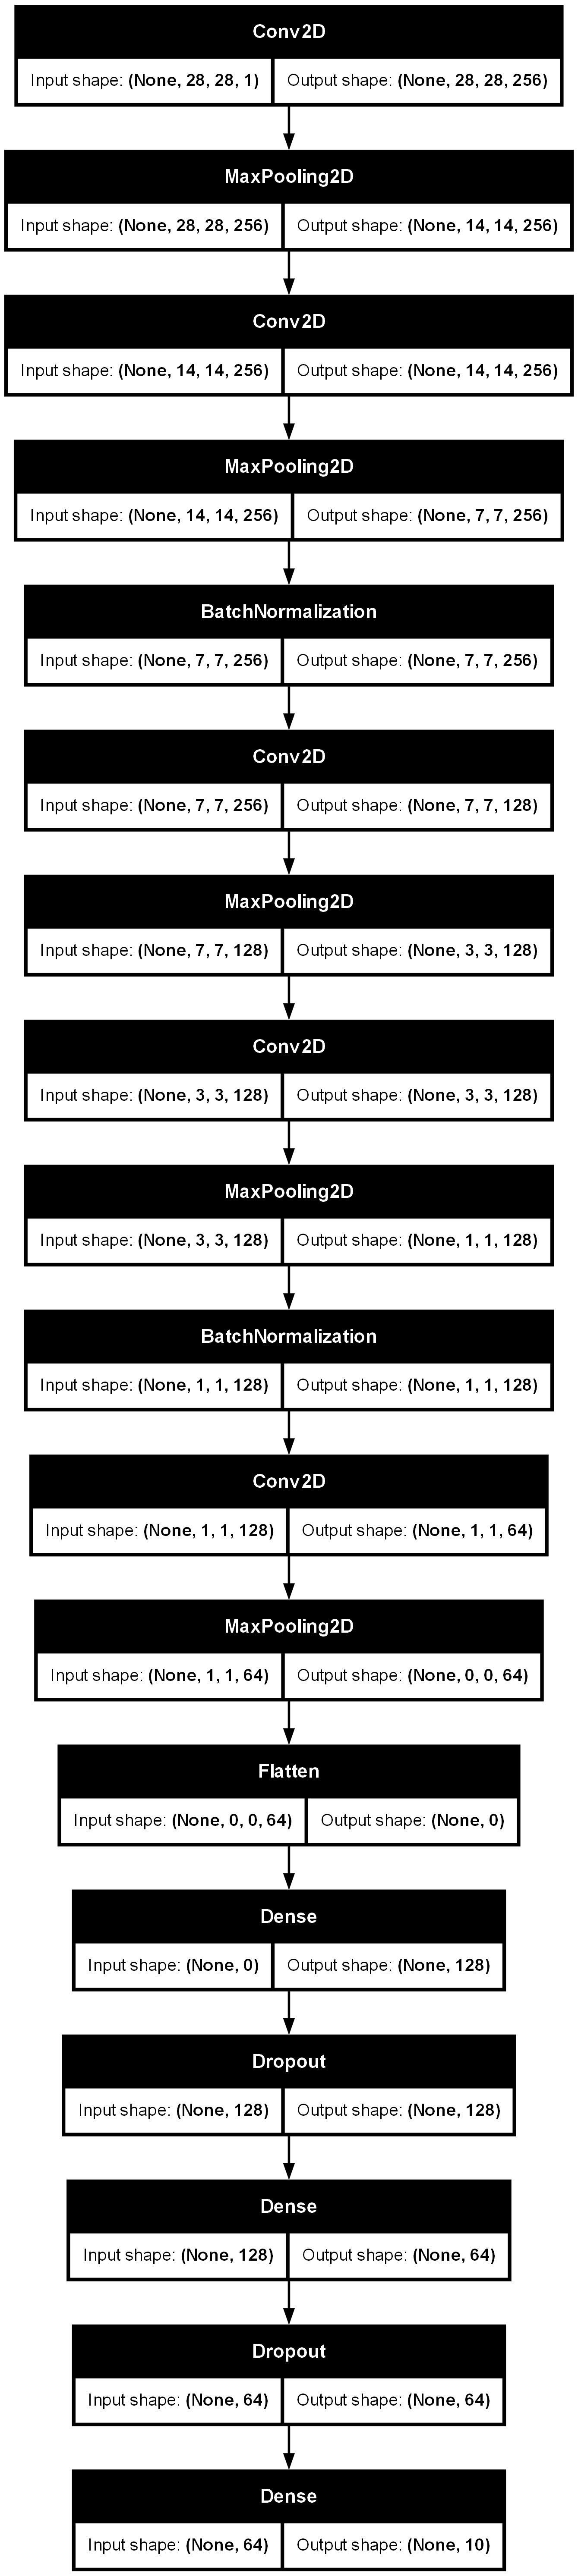

In [ ]:
tf.keras.utils.plot_model(model, show_shapes=True)

In [ ]:
model.compile(
    loss="sparse_categorical_crossentropy", 
    optimizer="nadam", metrics=["accuracy"])